# Inhaltsverzeichnis

| Abschnitt | Unterabschnitt |
|-----------|----------------|
| **[LSTM Monatliche Modelle](#ltsm-monthly-model)** | |
| **[Zusammenfassung](#zusammenfassung)** | |
| **[Modell laden, Residuen speichern und Testwerte mit Vorhersagen vergleichen](#modell-laden,-residuen-speichern-und-testwerte-mit-vorhersagen-vergleichen)** | |
| **[Stationarität der Residuen](#stationaritaet-der-residuen)** | |
| **[Cross validation](#cross-validation)** | |


## LSTM Monatliche Modelle


In [12]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import json

# Load the dataset
file_path = './Data_Waldbrand_Zeitreihen/monthly_data_merged/merged_monthly_with_o2_co2_fire_counts.csv'
data = pd.read_csv(file_path)

# Convert dates to datetime objects
data['DISCOVERY_DATE'] = pd.to_datetime(data['DISCOVERY_DATE'])
data['YearMonth'] = pd.to_datetime(data['YearMonth'])

# Add logarithm of monthly fire counts
data['LOG_FIRE_COUNTS'] = np.log1p(data['Monthly Fire Counts'])  # log1p to handle zero values safely

# Add lag features based on LOG_FIRE_COUNTS
n_lag = 12  # Number of lag months (1 year)
for i in range(1, n_lag + 1):
    data[f'lag_{i}'] = data['LOG_FIRE_COUNTS'].shift(i)

# Drop rows with NaN values caused by lags
data.dropna(inplace=True)

# Select features and target
features = ['MinTemperature', 'MaxTemperature', 'Inferred_Wind_Speed', 'Precipitation',# 'O2_seasonally','CO2_seasonally', 'O2_Value', 'CO2_Value',
             'Detrended_CO2', 'Detrended_O2', 'Month'] + \
           [f'lag_{i}' for i in range(1, n_lag + 1)]
target = 'LOG_FIRE_COUNTS'

# Prepare the data
X = data[features].values
y = data[target].values

# Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape features for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(80, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='log_cosh')

# Early Stopping and Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('./Data_Waldbrand_Zeitreihen/Model_Results/best_monthly_model_with_lags.keras',
                                   save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])

# Save the final trained model
model.save('./Data_Waldbrand_Zeitreihen/Model_Results/lstm_monthly_model_with_lags.keras')

# Save training history
history_dict = history.history
with open('./Data_Waldbrand_Zeitreihen/Model_Results/training_history_monthly_with_lags.json', 'w') as file:
    json.dump(history_dict, file)

print("Training complete. Model and history saved.")


Epoch 1/500


c:\Users\fsali\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 7.9181 - val_loss: 7.6820
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.6614 - val_loss: 6.8495
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.6973 - val_loss: 2.0359
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.9877 - val_loss: 1.7035
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.5009 - val_loss: 0.9951
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.1429 - val_loss: 1.5758
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1622 - val_loss: 0.9365
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8750 - val_loss: 0.6859
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6253 - val_loss: 0.5490
Epoch 10/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4563 - val_loss: 0.3793
Epoch 11/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3675 - val_loss: 0.3274
Epoch 12/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3169 - val_loss: 0.2687
E

## Zusammenfassung

In [1]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the trained LSTM model
model_file_path = './Data_Waldbrand_Zeitreihen/Model_Results/lstm_monthly_model_with_lags.keras'
model = load_model(model_file_path)

# Print the model summary
print("Model Summary:")
model.summary()

# Retrieve weights for all layers
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    print(f"\nLayer {i+1} ({layer.name}):")
    if len(weights) > 0:
        for w_i, w in enumerate(weights):
            print(f"  Weight {w_i+1}: Shape {np.shape(w)}")
    else:
        print("  No weights for this layer.")


Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 19, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 80)             │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │         4,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,465 (1.18 MB)

 Trainable params: 102,821 (401.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 205,644 (803.30 KB)


Layer 1 (lstm_9):
  Weight 1: Shape (1, 400)
  Weight 2: Shape (100, 400)
  Weight 3: Shape (400,)

Layer 2 (lstm_10):
  Weight 1: Shape (100, 320)
  Weight 2: Shape (80, 320)
  Weight 3: Shape (320,)

Layer 3 (dense_8):
  Weight 1: Shape (80, 50)
  Weight 2: Shape (50,)

Layer 4 (dense_9):
  Weight 1: Shape (50, 1)
  Weight 2: Shape (1,)


## Modell laden, Residuen speichern und Testwerte mit Vorhersagen vergleichen


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000013D583F7D80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Residuals saved at: ./Data_Waldbrand_Zeitreihen/monthly_data_merged/lstm_monthly_model_residuals.csv


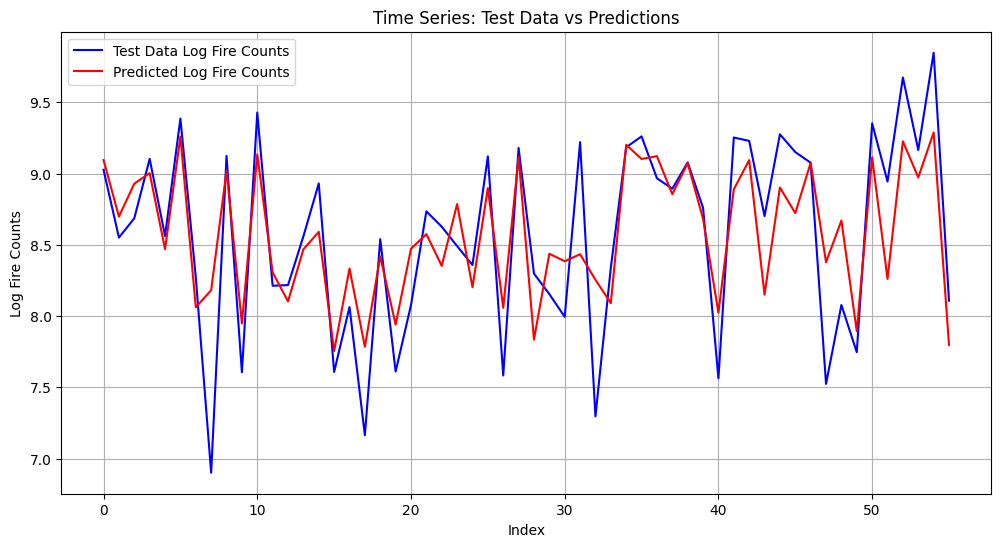

Test vs Predictions plot saved at: ./Abbildungen/lstm_monthly_test_vs_predictions.png


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

# Load the dataset
file_path = './Data_Waldbrand_Zeitreihen/monthly_data_merged/merged_monthly_with_o2_co2_fire_counts.csv'
data = pd.read_csv(file_path)

# Convert dates to datetime objects
data['DISCOVERY_DATE'] = pd.to_datetime(data['DISCOVERY_DATE'])
data['YearMonth'] = pd.to_datetime(data['YearMonth'])

# Add logarithm of monthly fire counts
data['LOG_FIRE_COUNTS'] = np.log1p(data['Monthly Fire Counts'])

# Add lag features
n_lag = 12  # Number of lag months
for i in range(1, n_lag + 1):
    data[f'lag_{i}'] = data['LOG_FIRE_COUNTS'].shift(i)

# Drop rows with NaN values caused by lags
data.dropna(inplace=True)

# Select features and target
features = ['MinTemperature', 'MaxTemperature', 'Inferred_Wind_Speed', 'Precipitation',
             'Detrended_CO2', 'Detrended_O2', 'Month'] + \
           [f'lag_{i}' for i in range(1, n_lag + 1)]
target = 'LOG_FIRE_COUNTS'

# Prepare the data
X = data[features].values
y = data[target].values

# Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape features for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the model
model_path = './Data_Waldbrand_Zeitreihen/Model_Results/lstm_monthly_model_with_lags.keras'
model = load_model(model_path)

# Generate predictions
predicted_log_fire_counts = model.predict(X_val)

# Create a DataFrame for actual, predicted values, and residuals
df = pd.DataFrame({
    
    "Actual": y_val.flatten(),
    "Predicted": predicted_log_fire_counts.flatten(),
    "Residuals": y_val.flatten() - predicted_log_fire_counts.flatten()
})

# Save residuals to a CSV file
residuals_output_path = './Data_Waldbrand_Zeitreihen/monthly_data_merged/lstm_monthly_model_residuals.csv'
os.makedirs(os.path.dirname(residuals_output_path), exist_ok=True)
df[['Residuals']].to_csv(residuals_output_path, index=False)
print(f"Residuals saved at: {residuals_output_path}")

# Plot the test set with predicted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Actual"], label="Test Data Log Fire Counts", color="blue", linestyle="-")
plt.plot(df.index, df["Predicted"], label="Predicted Log Fire Counts", color="red", linestyle="-")
plt.title("Time Series: Test Data vs Predictions")
plt.xlabel("Index")
plt.ylabel("Log Fire Counts")
plt.legend()
plt.grid(True)

# Save the plot
plot_output_path = './Abbildungen/lstm_monthly_test_vs_predictions.png'
os.makedirs(os.path.dirname(plot_output_path), exist_ok=True)
plt.savefig(plot_output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Test vs Predictions plot saved at: {plot_output_path}")


# Residuen-Visualisierung


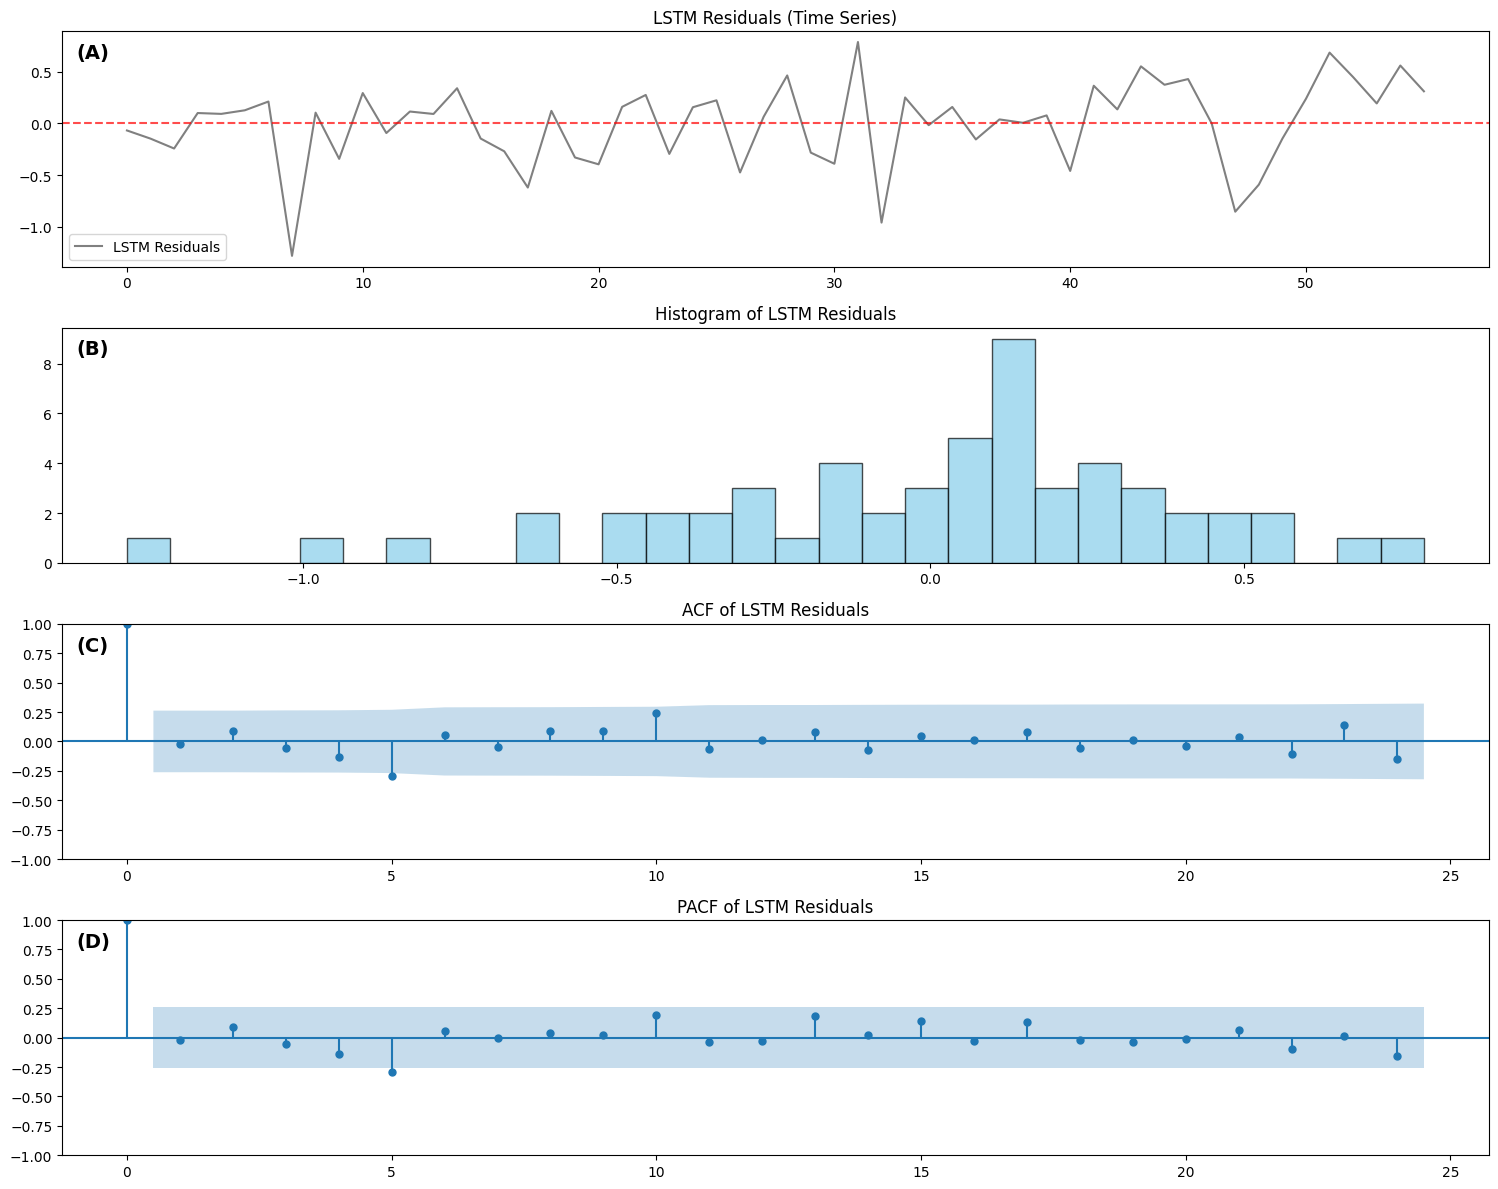

Residual analysis plot saved at: ./Abbildungen\lstm_monthly_residual_analysis.png


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os

# Load the residuals data
residuals_file_path = './Data_Waldbrand_Zeitreihen/monthly_data_merged/lstm_monthly_model_residuals.csv'
residuals_df = pd.read_csv(residuals_file_path)

# Ensure the Residuals column exists
if 'Residuals' not in residuals_df.columns:
    raise ValueError("The file does not contain a 'Residuals' column.")

# Extract residuals
residuals = residuals_df['Residuals']

# Check for NaN values in the residuals
if residuals.isna().any():
    print("Warning: NaN values found in residuals. These will be dropped for analysis.")
    residuals = residuals.dropna()

# Residual Analysis without Aggregation
plt.figure(figsize=(15, 12))

# Residual time series
plt.subplot(411)
plt.plot(residuals, label='LSTM Residuals', color='gray')
plt.axhline(0, linestyle='--', color='red', alpha=0.7)
plt.text(0.01, 0.95, '(A)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
plt.title('LSTM Residuals (Time Series)')
plt.legend()

# Histogram of residuals
plt.subplot(412)
plt.hist(residuals.values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.text(0.01, 0.95, '(B)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
plt.title('Histogram of LSTM Residuals')

# ACF plot of residuals
plt.subplot(413)
plot_acf(residuals, lags=24, ax=plt.gca(), title='ACF of LSTM Residuals', alpha=0.05)
plt.text(0.01, 0.95, '(C)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# PACF plot of residuals
plt.subplot(414)
plot_pacf(residuals, lags=24, ax=plt.gca(), title='PACF of LSTM Residuals', alpha=0.05)
plt.text(0.01, 0.95, '(D)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Save the plot to the 'Abbildungen' folder
output_dir = './Abbildungen'
os.makedirs(output_dir, exist_ok=True)
residuals_plot_path = os.path.join(output_dir, 'lstm_monthly_residual_analysis.png')
plt.tight_layout()
plt.savefig(residuals_plot_path, dpi=300)
plt.show()

print(f"Residual analysis plot saved at: {residuals_plot_path}")


## Stationarität der Residuen


In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import kpss, adfuller

# Suppress warnings in the output
import warnings
warnings.filterwarnings("ignore")

# Load the residuals data from the previously created CSV file
daily_residuals_output_csv_path = "./Data_Waldbrand_Zeitreihen/monthly_data_merged/lstm_monthly_model_residuals.csv"

# Ensure the file exists and handle errors
try:
    arima_residuals = pd.read_csv(daily_residuals_output_csv_path, parse_dates=True)
    if 'Residuals' not in arima_residuals.columns:
        raise ValueError("The file does not contain a 'Residuals' column.")
except FileNotFoundError:
    raise FileNotFoundError(f"The file {daily_residuals_output_csv_path} does not exist.")
except ValueError as e:
    raise ValueError(e)

# Extract the residuals
residuals = arima_residuals['Residuals']

# Perform the Augmented Dickey-Fuller test on the residuals
adf_test = adfuller(residuals.dropna())

# Output the results for ADF test
print('ADF Statistic (Residuals): %f' % adf_test[0])
print('p-value (Residuals): %f' % adf_test[1])
print('Critical Values (Residuals):')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

# Determine stationarity based on ADF test
if adf_test[1] < 0.05:
    print("The residuals are stationary according to the ADF test.")
else:
    print("The residuals are not stationary according to the ADF test.")

# Perform the KPSS test on the residuals
kpss_test = kpss(residuals.dropna(), regression='c')  # 'c' for constant in the regression

# Output the results for KPSS test
print('KPSS Statistic (Residuals): %f' % kpss_test[0])
print('p-value (Residuals): %f' % kpss_test[1])
print('Critical Values (Residuals):')
for key, value in kpss_test[3].items():
    print('\t%s: %.3f' % (key, value))

# Determine stationarity based on KPSS test
if kpss_test[1] < 0.05:
    print("The residuals are not stationary according to the KPSS test.")
else:
    print("The residuals are stationary according to the KPSS test.")


ADF Statistic (Residuals): -4.581734
p-value (Residuals): 0.000140
Critical Values (Residuals):
	1%: -3.566
	5%: -2.920
	10%: -2.598
The residuals are stationary according to the ADF test.
KPSS Statistic (Residuals): 0.342794
p-value (Residuals): 0.100000
Critical Values (Residuals):
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
The residuals are stationary according to the KPSS test.


## Cross validation

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import os
import json

# Load the dataset
file_path = './Data_Waldbrand_Zeitreihen/monthly_data_merged/merged_monthly_with_o2_co2_fire_counts.csv'
data = pd.read_csv(file_path)

# Convert dates to datetime objects
data['DISCOVERY_DATE'] = pd.to_datetime(data['DISCOVERY_DATE'])
data['YearMonth'] = pd.to_datetime(data['YearMonth'])

# Add logarithm of monthly fire counts
data['LOG_FIRE_COUNTS'] = np.log1p(data['Monthly Fire Counts'])  # log1p to handle zero values safely

# Add lag features based on LOG_FIRE_COUNTS
n_lag = 12  # Number of lag months (1 year)
for i in range(1, n_lag + 1):
    data[f'lag_{i}'] = data['LOG_FIRE_COUNTS'].shift(i)

# Drop rows with NaN values caused by lags
data.dropna(inplace=True)

# Select features and target
features = ['MinTemperature', 'MaxTemperature', 'Inferred_Wind_Speed', 'Precipitation',
            'Detrended_CO2', 'Detrended_O2', 'Month'] + \
           [f'lag_{i}' for i in range(1, n_lag + 1)]
target = 'LOG_FIRE_COUNTS'

# Prepare the data
X = data[features].values
y = data[target].values

# Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape features for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into train and validation sets
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores, mae_scores, rmse_scores = [], [], []

# Load the pre-trained model
model_path = './Data_Waldbrand_Zeitreihen/Model_Results/lstm_monthly_model_with_lags.keras'
model = load_model(model_path)

# Cross-validation loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Predict using the model
    predictions = model.predict(X_test)

    # Calculate different error metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)

    # Store the scores for final averaging
    mse_scores.append(round(mse, 4))
    mae_scores.append(round(mae, 4))
    rmse_scores.append(round(rmse, 4))

# Average scores across all folds
average_scores = {
    'Metric': ['MSE', 'MAE', 'RMSE'],
    'Average Value': [
        round(np.mean(mse_scores), 4),
        round(np.mean(mae_scores), 4),
        round(np.mean(rmse_scores), 4)
    ]
}

# Create a DataFrame for the averaged values
averaged_scores_df = pd.DataFrame(average_scores)

# Define the path to save the table as an image
output_dir = "./Abbildungen"
os.makedirs(output_dir, exist_ok=True)
output_image_path = os.path.join(output_dir, "NNR_monthly_cross_validation_scores.png")

# Save the table as a LaTeX-like styled image
fig, ax = plt.subplots(figsize=(5, 1.5))  # Reduced figure size to minimize margins
ax.axis('tight')
ax.axis('off')

# Create a better-presented table with LaTeX styling
cell_text = [[f"{val}" for val in row] for row in averaged_scores_df.values]
col_labels = averaged_scores_df.columns
ax.table(cellText=cell_text, colLabels=col_labels, loc='center', cellLoc='center', edges='horizontal')

plt.savefig(output_image_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

print(f"Cross-validation scores table saved at: {output_image_path}")

# Print average scores
print("Average MSE:", round(np.mean(mse_scores), 4))
print("Average MAE:", round(np.mean(mae_scores), 4))
print("Average RMSE:", round(np.mean(rmse_scores), 4))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Cross-validation scores table saved at: ./Abbildungen\NNR_monthly_cross_validation_scores.png
Average MSE: 0.0902
Average MAE: 0.2312
Average RMSE: 0.2937
